In [1]:
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Computing rdf between species AU...


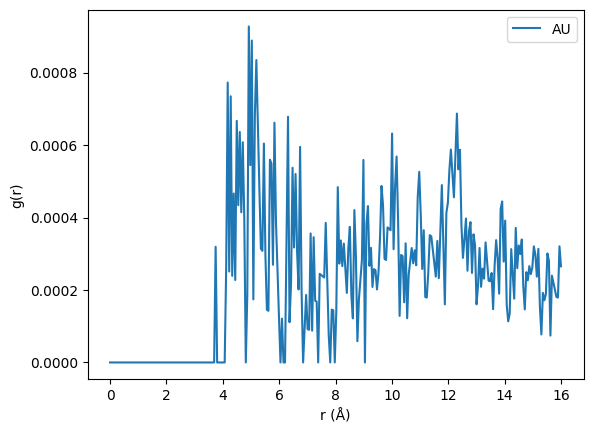

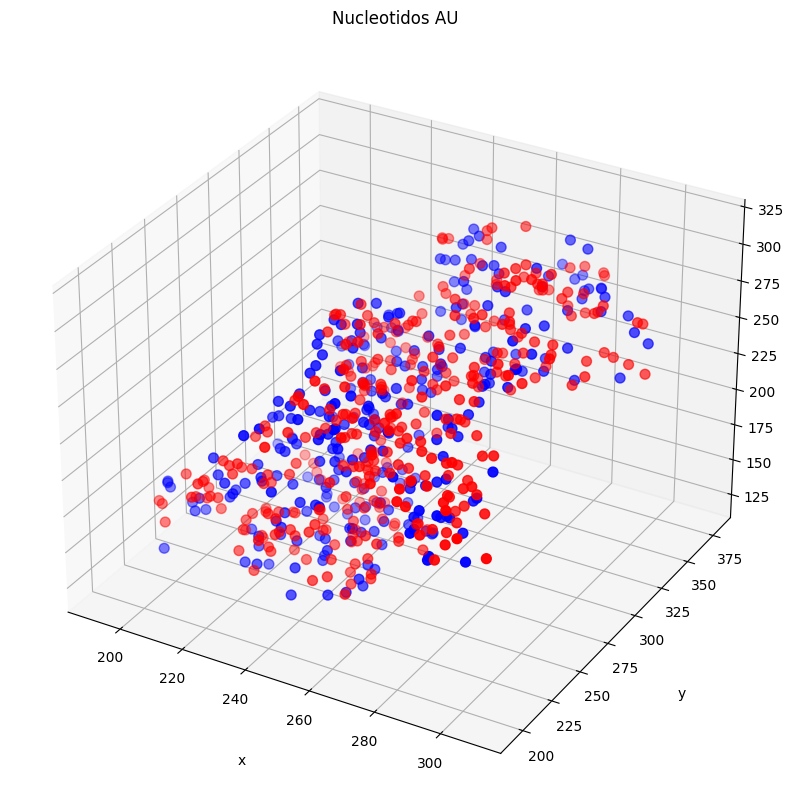

In [9]:

class RDF:
    def __init__(self, filename, resolution):

        """ Molecular weights  """

        Hidrogen = 1.00784
        Oxigen = 15.999
        Nitrogen = 14.0067
        Carbon = 12.011
        Fosforo = 30.973762


        with open( filename ) as f:
            data = f.readlines()

        self.Ats_inf = []

        for line in range(len(data)):
            if 'ATOM' in data[line]:
                l_inf = data[line].split()[5]
                if l_inf == 'A' or l_inf == 'C' or l_inf == 'G' or l_inf == 'U':
                    self.Ats_inf.append(data[line])


        """ Total atoms number  """

        self.N_atoms = len(self.Ats_inf)


        """ Matrix with mass, nucleotide, residue, coordinates X, Y, Z """

        Matrix = np.zeros( ( self.N_atoms , 6 ) )

        """ Atomic weights are substituted by their numerical values,
                and nucleotides types by 1234 """

        for j, line in enumerate(self.Ats_inf):
            if  line.split()[2] == 'H':
                Matrix[j, 0] = Hidrogen
            elif  line.split()[2] == 'O':
                Matrix[j, 0] = Oxigen
            elif  line.split()[2] == 'N':
                Matrix[j, 0] = Nitrogen
            elif  line.split()[2] == 'C':
                Matrix[j, 0] = Carbon
            elif  line.split()[2] == 'P':
                Matrix[j, 0] = Fosforo
            else:
                print(0)
            if  line.split()[5] == 'A':
                Matrix[j, 1] = 1
            elif  line.split()[5] == 'C':
                Matrix[j, 1] = 2
            elif  line.split()[5] == 'G':
                Matrix[j, 1] = 3
            elif  line.split()[5] == 'U':
                Matrix[j, 1] = 4
            else:
                print(0)
            Matrix[j,2:] = [line.split()[8],
                    line.split()[10], line.split()[11],line.split()[12]]


        A = []
        C = []
        G = []
        U = []
        stack = []

        """ Calcula de los centros de masas y de guardar los en listas para cada ACGU """
        l = 0
        for i in range(1, int(Matrix[self.N_atoms-1,2]) + 1):
            for j in range(len(Matrix)):
                if int(Matrix[j,2]) == i:
                    stack.append([Matrix[j,0], Matrix[j,3], Matrix[j,4], Matrix[j,5]])
                    ACGU = int(Matrix[j,1])

            if int(len(stack)) == 0:
                l = l + 1
            else:
                stack = np.array(stack)
                CM = self.CoM(stack)

                if ACGU == 1:
                    A.append([CM[0], CM[1], CM[2]])
                elif ACGU == 2:
                    C.append([CM[0], CM[1], CM[2]])
                elif ACGU == 3:
                    G.append([CM[0], CM[1], CM[2]])
                elif ACGU == 4:
                    U.append([CM[0], CM[1], CM[2]])
            stack = []

        self.A = np.array(A)
        self.C = np.array(C)
        self.G = np.array(G)
        self.U = np.array(U)

        self.N_A = len(self.A)
        self.N_C = len(self.C)
        self.N_G = len(self.G)
        self.N_U = len(self.U)

        Max_values = np.amax( Matrix, axis = 0 )
        Min_values = np.amin( Matrix, axis = 0 )

        self.X_max = max( abs(int(Max_values[3])), abs(int( Min_values[3] )))
        self.Y_max = max( abs(int(Max_values[4])), abs(int( Min_values[4] )))
        self.Z_max = max( abs(int(Max_values[5])), abs(int( Min_values[5] )))

        self.resolution = resolution


        #########################################################################

    def CoM(self, stack):
        """ Comute the center of mass of an array of positions """

        M = np.sum(stack[:,0])
        X = 0
        Y = 0
        Z = 0
        for i in range(len(stack)):
            X += stack[i,0] * stack[i,1]
            Y += stack[i,0] * stack[i,2]
            Z += stack[i,0] * stack[i,3]
        return (X, Y, Z)/M

    def Atoms_data(self, Atoms_inf, Atoms_filename):
        """ Creates a document .ciff with the information of the atoms """

        with open( Atoms_filename + '_raw.cif','w') as g:
            for line in Atoms_inf:
                g.write(line)

    def distance(self, a, b):
        """ Computes distance according to X_max, Y_max y Z_max  """

        dx = abs(a[0] - b[0])
        x = min(dx, abs(self.X_max - dx))

        dy = abs(a[1] - b[1])
        y = min(dy, abs(self.Y_max - dy))

        dz = abs(a[2] - b[2])
        z = min(dz, abs(self.Z_max - dz))

        return np.sqrt(x**2 + y**2 + z**2)

    def density_number(self, N_A, N_B):
        """ Computes density number """

        dn = N_A * N_B /(self.X_max * self.Y_max * self.Z_max)
        return dn

    def volume(self, r):
        """ Computes volume """

        volume = ( 4.0 * sp.pi * r**3) / 3.0
        return volume

    def WCpairs(self, specie_ab):
        if specie_ab == 'AU':
            print('Computing rdf between species AU...')
            rdf_ab = self.compute_rdf(self.A, self.U, self.N_A, self.N_U, self.resolution)
        elif specie_ab == 'GC':
            print('Computing rdf between species GC...')
            rdf_ab = self.compute_rdf( self.G, self.C, self.N_G, self.N_C, self.resolution)
        else:
            print('Not valid pairs')
            rdf_ab = 0
        return rdf_ab


    def compute_rdf(self, Species_A, Species_B, N_A, N_B, resolution):
        """ el radio de corte es la mitad de la longitud minima de las dimensiones de la celda """

        resolution = 300
        N_species = N_A + N_B

        r_cutoff =  16 #min( min(X_max, Y_max ), Z_max ) / 2.0
        dr = r_cutoff / self.resolution
        volumes = np.zeros(self.resolution)

        self.radii = np.linspace(0.0, self.resolution * dr, self.resolution)
        self.rdf = np.zeros((int(len(Species_A)), self.resolution))


        for i, part_1 in enumerate(Species_A):

            for j, part_2 in enumerate(Species_B):

                dist = self.distance(part_1, part_2)
                index = int(dist / dr)
                if 0 < index < self.resolution:
                    self.rdf[i,index] += 2.0

        for j in range(resolution):
            r1 = j*dr
            r2 = r1 + dr
            v1 = self.volume(r1)
            v2 = self.volume(r2)
            volumes[j] += v2 - v1

        

        self.rdf = np.mean(self.rdf, axis = 0)
        
        self.rdf = self.rdf / N_species


        for i, value in enumerate(self.rdf):
            self.rdf[i] = value/ (volumes[i] * self.density_number(N_A,N_B))

        return self.radii, self.rdf

    def plot_rdf(self, specie_ab, filename):

        rad, rdff = self.WCpairs( specie_ab )

        plt.xlabel( 'r (Å)')
        plt.ylabel(  'g(r)' )

        plt.plot(rad, rdff, label = specie_ab)
        plt.legend()
        plt.savefig( 'rdf_' + filename + specie_ab + '.pdf' , dpi= self.resolution, bbox_inches='tight', format='pdf')
        #plt.show()

    def plot_rdf_3d(self, species_ab, filename):

        if species_ab == 'AU':
            species_A = self.A
            species_B = self.U
        elif specie_ab == 'GC':
            species_A = self.G
            species_B = self.C
        else:
            return print('Not valid pairs')


        X_1 = species_A[:,0]
        Y_1 = species_A[:,1]
        Z_1 = species_A[:,2]

        X_2 = species_B[:,0]
        Y_2 = species_B[:,1]
        Z_2 = species_B[:,2]

        fig3d = plt.figure( figsize = ( 10, 10) )
        ax = plt. axes( projection = '3d')
        ax.grid()

        ax.scatter( X_1, Y_1, Z_1, c = 'r', s = 50)
        ax.scatter( X_2, Y_2, Z_2, c = 'b', s = 50)
        ax.set_title( 'Nucleotidos ' + species_ab )

        ax.set_xlabel('x', labelpad = 20)
        ax.set_ylabel('y', labelpad = 20)
        ax.set_zlabel('z', labelpad = 20)

        #plt.show()
        plt.savefig('rdf_' + filename + species_ab + '_3d' + '.pdf')


GR = RDF('6awc.cif', 300)

#GR.Atoms_data(GR.Ats_inf)
#print(GR.A)
#print(GR.N_atoms)
#GR.Atoms_data(GR.Ats_inf, '1esh')

#Datos = GR.WCpairs('AU')
#print(Datos)

GR.plot_rdf('AU', '6awc')
GR.plot_rdf_3d('AU', '6awc')


Computing rdf between species AU...


UnboundLocalError: local variable 'rdf' referenced before assignment